In [1]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.layers.core import Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model
from keras import metrics
from keras import regularizers



import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


Using TensorFlow backend.


## Import files

In [2]:
from PIL import Image
import math

In [3]:
rebuild_raw = False
rebuild_preprocessed = False

if rebuild_raw:
    X = np.zeros((1,224,224,3))
    y = np.zeros((1,1))
    for label in range(1,4):
        count = 0
        for filename in os.listdir("/home/cedoz/kaggle_cervical/data/raw/train/Type_%d"%label):
            count += 1
            img = Image.open("/home/cedoz/kaggle_cervical/data/raw/train/Type_%d/%s"%(label,filename))
            width, height = img.size
            delta = abs(width - height)
            if width < height:
                img = img.crop((0,int(math.ceil(delta/2)),width,height-int(math.ceil(delta/2))))
            else:
                img = img.crop((int(math.ceil(delta/2)),0,width-int(math.ceil(delta/2)),height))
            img.thumbnail((224,224))
            pixels = list(img.getdata())
            pixels = np.array(pixels)
            pixels = pixels.reshape((224,224,3)) 
            pixels = np.expand_dims(pixels, axis=0)                               
            X = np.append(X, pixels, axis = 0)  
            if (count%20 ==0):
                print ("preprocessing image %d of type%d"%(count,label))
            img.close()
        y = np.append(y, (label-1)*np.ones((count,1)), axis=0)
    for label in range(1,4):
        count = 0
        for filename in os.listdir("/home/cedoz/kaggle_cervical/data/raw/train/additional_Type_%d"%label):
            count += 1
            img = Image.open("/home/cedoz/kaggle_cervical/data/raw/train/additional_Type_%d/%s"%(label,filename))
            width, height = img.size
            delta = abs(width - height)
            if width < height:
                img = img.crop((0,int(math.ceil(delta/2)),width,height-int(math.ceil(delta/2))))
            else:
                img = img.crop((int(math.ceil(delta/2)),0,width-int(math.ceil(delta/2)),height))
            img.thumbnail((224,224))
            pixels = np.array(list(img.getdata()))
            pixels = pixels.reshape((224,224,3)) 
            pixels = np.expand_dims(pixels, axis=0)                               
            X = np.append(X, pixels, axis = 0)  
            if (count%20 ==0):
                print ("preprocessing image %d of type%d additional"%(count,label))
            img.close()
        y = np.append(y, (label-1)*np.ones((count,1)), axis=0)
    y = y[1:]
    X = X[1:]
    np.save('X.npy', X)
    np.save('y.npy', y)

if rebuild_preprocessed:
    X = np.zeros((1,224,224,3))
    y = np.zeros((1,1))
    for label in range(1,4):
        count = 0
        for filename in os.listdir("/home/cedoz/kaggle_cervical/data/preprocessed/train/Type_%d"%label):
            count += 1
            img = Image.open("/home/cedoz/kaggle_cervical/data/preprocessed/train/Type_%d/%s"%(label,filename))
            width, height = img.size
            delta = abs(width - height)
            if width < height:
                img = img.crop((0,int(math.ceil(delta/2)),width,height-int(math.ceil(delta/2))))
            else:
                img = img.crop((int(math.ceil(delta/2)),0,width-int(math.ceil(delta/2)),height))
            img.thumbnail((224,224))  
            if (img.size[1] < 223 or img.size[0] < 223):
                img.close()
                count -= 1
            else:
                pixels = np.array(list(img.getdata()))
                if (img.size[0] == 223 and img.size[1] == 224):
                    pixels = pixels.reshape((223,224,3)) 
                    pixels = np.append(np.zeros((1,224,3)), pixels, axis=0)
                if (img.size[1] == 223 and img.size[0] == 224):
                    pixels = pixels.reshape((224,223,3)) 
                    pixels = np.append(np.zeros((224,1,3)), pixels, axis=1)
                if (img.size[1] == 223 and img.size[0] == 223):
                    pixels = pixels.reshape((223,223,3)) 
                    pixels = np.append(np.zeros((223,1,3)), pixels, axis=1)
                    pixels = np.append(np.zeros((1,224,3)), pixels, axis=0)
                pixels = pixels.reshape((224,224,3)) 
                pixels = np.expand_dims(pixels, axis=0)                               
                X = np.append(X, pixels, axis = 0)  
                if (count%20 ==0):
                    print ("preprocessing image %d of type%d"%(count,label))
                img.close()
        y = np.append(y, (label-1)*np.ones((count,1)), axis=0)
    y = y[1:]
    X = X[1:]
    np.save('X_preprocessed.npy', X)
    np.save('y_preprocessed.npy', y)
    
else:
    X_preprocessed = np.load('X_preprocessed.npy')
    y_preprocessed = np.load('y_preprocessed.npy')
    X = np.load('X.npy')
    y = np.load('y.npy')
    X_small = np.load('X_raw.npy')
    y_small = np.load('y_raw.npy')

In [4]:
from PIL import Image

rebuild_test = False
if rebuild_test:
    X = np.zeros((1,224,224,3))
    count = 0 
    for filename in os.listdir("/home/cedoz/kaggle_cervical/data/raw/test"):
        count += 1
        img = Image.open("/home/cedoz/kaggle_cervical/data/raw/test/%s"%filename)
        width, height = img.size
        delta = abs(width - height)
        if width < height:
            img = img.crop((0,int(delta/2),width,height-int(delta/2)))
        else:
            img = img.crop((int(delta/2),0,width-int(delta/2),height))
        img.thumbnail((224,224))
        pixels = list(img.getdata())
        pixels = np.array(pixels)
        pixels = pixels.reshape((224,224,3)) 
        pixels = np.expand_dims(pixels, axis = 0)                               
        X = np.append(X, pixels, axis = 0)  
        if (count%20 ==0):
            print ("preprocessing image %d of test set"%count)
        img.close()
    X = X[1:]
    np.save('X_test.npy', X)
else:
    X_test = np.load('X_test.npy')

In [5]:
from sklearn.model_selection import train_test_split
X, _, y, _ = train_test_split(X, y, test_size=0, random_state=0)
X_preprocessed, _, y_preprocessed, _ = train_test_split(X_preprocessed, y_preprocessed, test_size=0, random_state=0)
X_small, _, y_small, _ = train_test_split(X_small, y_small, test_size=0, random_state=0)

one_hot_y = to_categorical(y, num_classes=3)
one_hot_y_preprocessed = to_categorical(y_preprocessed, num_classes=3)
one_hot_y_small = to_categorical(y_small, num_classes=3)

print(X.shape, one_hot_y.shape)
print(X_preprocessed.shape, one_hot_y_preprocessed.shape)
print(X_small.shape, one_hot_y_small.shape)


MemoryError: 

## Deep Learning

In [38]:
import keras.backend as K

def all_accuracies(y_true, y_pred):
    classes = K.shape(y_pred)[1]
    accuracies = []
    for i in classes:
        K.equal(y_true[,i], K.ones(K.shape(y_true[,i]))
        y_pred_i = y_pred[K.equal(y_true[,i], K.ones(K.shape(y_true[,i])),]
        acc_i = K.mean(K.equal(K.ones(K.shape(y_pred_i)), K.round(y_pred_i)), axis=-1)
        accuracies = accuracies.append(acc_i)
    return accuracies

SyntaxError: invalid syntax (<ipython-input-38-bc0cba4a091e>, line 7)

### Inception V3

In [6]:
# create the base pre-trained model

base_model = InceptionV3(weights='imagenet', include_top=False, pooling = 'avg', input_shape = (224,224,3))
x = base_model.output
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
logits = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=logits)

for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
adam = Adam(lr=3e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics = ['accuracy'])

history1 = model.fit(X, one_hot_y, batch_size=32, epochs=10, verbose=1, validation_split=0.2)

model.save('models/InceptionV3_inter_3e-4.h5')

Train on 6569 samples, validate on 1643 samples
Epoch 1/10
6569/6569 [==============================] - 76s - loss: 1.0573 - acc: 0.4814 - val_loss: 0.9620 - val_acc: 0.5393
Epoch 2/10
6569/6569 [==============================] - 73s - loss: 0.9999 - acc: 0.5089 - val_loss: 0.9857 - val_acc: 0.5435
Epoch 3/10
6569/6569 [==============================] - 73s - loss: 0.9758 - acc: 0.5215 - val_loss: 0.9525 - val_acc: 0.5520
Epoch 4/10
6569/6569 [==============================] - 74s - loss: 0.9606 - acc: 0.5327 - val_loss: 0.9375 - val_acc: 0.5478
Epoch 5/10
6569/6569 [==============================] - 74s - loss: 0.9516 - acc: 0.5360 - val_loss: 0.9685 - val_acc: 0.5508
Epoch 6/10
6569/6569 [==============================] - 73s - loss: 0.9440 - acc: 0.5386 - val_loss: 0.9440 - val_acc: 0.5551
Epoch 7/10
6569/6569 [==============================] - 73s - loss: 0.9451 - acc: 0.5389 - val_loss: 0.9229 - val_acc: 0.5526
Epoch 8/10
6569/6569 [==============================] - 73s - loss: 0.

In [7]:
#Fine tune the two previous inception layers
#model = load_model('models/InceptionV3_inter_3e-4.h5')

for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

adam = Adam(lr=5e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics = ['accuracy'])

history2 = model.fit(X, one_hot_y, batch_size=32, epochs=15, verbose=1, validation_split=0.2)
#model.save('models/InceptionV3_final_3e-4_5e-6.h5')

Train on 6569 samples, validate on 1643 samples
Epoch 1/10
6569/6569 [==============================] - 87s - loss: 0.9074 - acc: 0.5617 - val_loss: 0.9181 - val_acc: 0.5533
Epoch 2/10
6569/6569 [==============================] - 84s - loss: 0.8920 - acc: 0.5684 - val_loss: 0.9094 - val_acc: 0.5642
Epoch 3/10
6569/6569 [==============================] - 85s - loss: 0.8853 - acc: 0.5645 - val_loss: 0.9011 - val_acc: 0.5740
Epoch 4/10
6569/6569 [==============================] - 85s - loss: 0.8570 - acc: 0.5792 - val_loss: 0.8926 - val_acc: 0.5758
Epoch 5/10
6569/6569 [==============================] - 85s - loss: 0.8351 - acc: 0.6044 - val_loss: 0.8832 - val_acc: 0.5806
Epoch 6/10
6569/6569 [==============================] - 84s - loss: 0.8175 - acc: 0.6117 - val_loss: 0.8756 - val_acc: 0.5788
Epoch 7/10
6569/6569 [==============================] - 85s - loss: 0.7910 - acc: 0.6258 - val_loss: 0.8671 - val_acc: 0.5843
Epoch 8/10
6569/6569 [==============================] - 85s - loss: 0.

In [12]:
history2 = model.fit(X, one_hot_y, batch_size=32, epochs=2, verbose=1, validation_split=0.2)

Train on 6569 samples, validate on 1643 samples
Epoch 1/2
6569/6569 [==============================] - 85s - loss: 0.5811 - acc: 0.7573 - val_loss: 0.8270 - val_acc: 0.6086
Epoch 2/2
6569/6569 [==============================] - 85s - loss: 0.5340 - acc: 0.7736 - val_loss: 0.8262 - val_acc: 0.6153


### Inception V3 reduced (8 inception modules)

In [18]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False, pooling = 'avg', input_shape = (224,224,3))
for i in range(311-248):
    base_model.layers.pop()
x = base_model.output
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
logits = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=logits)
print(len(model.layers))
for layer in base_model.layers:
    layer.trainable = False


# compile the model (should be done *after* setting layers to non-trainable)
#adam = Adam(lr=3e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)

model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics = ['accuracy'])
history1 = model.fit(X_train, one_hot_y_train, batch_size=32, epochs=10, verbose=1, validation_split=0.2)

              
model.save('models/InceptionV3_reduced_inter_3e-6.h5')

317
Train on 6569 samples, validate on 1643 samples
Epoch 1/10
6569/6569 [==============================] - 97s - loss: 1.0718 - acc: 0.4809 - val_loss: 0.9576 - val_acc: 0.5423
Epoch 2/10
6569/6569 [==============================] - 88s - loss: 1.0089 - acc: 0.5068 - val_loss: 0.9407 - val_acc: 0.5484
Epoch 3/10
6569/6569 [==============================] - 88s - loss: 0.9737 - acc: 0.5238 - val_loss: 0.9253 - val_acc: 0.5545
Epoch 4/10
6569/6569 [==============================] - 88s - loss: 0.9367 - acc: 0.5456 - val_loss: 0.9148 - val_acc: 0.5551
Epoch 5/10
6569/6569 [==============================] - 88s - loss: 0.9020 - acc: 0.5698 - val_loss: 0.9029 - val_acc: 0.5630
Epoch 6/10
6569/6569 [==============================] - 88s - loss: 0.8685 - acc: 0.5897 - val_loss: 0.8909 - val_acc: 0.5697
Epoch 7/10
6569/6569 [==============================] - 88s - loss: 0.8131 - acc: 0.6179 - val_loss: 0.8860 - val_acc: 0.5849
Epoch 8/10
6569/6569 [==============================] - 88s - loss

KeyboardInterrupt: 

In [11]:
#Fine tune the two previous inception layers

model = load_model('models/InceptionV3_reduced_inter_1e-6.h5')

for layer in model.layers[:197]:
   layer.trainable = False
for layer in model.layers[197:]:
   layer.trainable = True

adam = Adam(lr=1e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics = ['accuracy'])

history2 = model.fit(X_train, one_hot_y_train, batch_size=32, epochs=10, verbose=1, validation_split=0.2)
model.save('models/InceptionV3_final_5e-5_5e-6.h5')

Train on 6569 samples, validate on 1643 samples
Epoch 1/10
6569/6569 [==============================] - 110s - loss: 1.0238 - acc: 0.5034 - val_loss: 0.9722 - val_acc: 0.5447
Epoch 2/10
1984/6569 [========>.....................] - ETA: 60s - loss: 1.0243 - acc: 0.5020

KeyboardInterrupt: 

### Inception V3 reduced (6 inception modules)

In [ ]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False, pooling = 'avg', input_shape = (224,224,3))
for i in range(311-196):
    base_model.layers.pop()
x = base_model.output
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
logits = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=logits)
print(len(model.layers))
for layer in base_model.layers:
    layer.trainable = False


# compile the model (should be done *after* setting layers to non-trainable)
#adam = Adam(lr=3e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)

model.compile(optimizer=Adam(lr=5e-6), loss='categorical_crossentropy', metrics = ['accuracy'])
history1 = model.fit(X, one_hot_y, batch_size=32, epochs=10, verbose=1, validation_split=0.2)
              
model.save('models/InceptionV3_reduced6_inter_5e-6.h5')

317
Train on 6569 samples, validate on 1643 samples
Epoch 1/10
5376/6569 [=======================>......] - ETA: 15s - loss: 1.0802 - acc: 0.4591

In [24]:
#Fine tune the two previous inception layers

model = load_model('models/InceptionV3_reduced6_inter_5e-6.h5')

for layer in model.layers[:133]:
   layer.trainable = False
for layer in model.layers[133:]:
   layer.trainable = True

adam = Adam(lr=1e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics = ['accuracy'])

history2 = model.fit(X_train, one_hot_y_train, batch_size=32, epochs=10, verbose=1, validation_split=0.2)
model.save('models/InceptionV3_final_5e-6_1e-6.h5')

Train on 6569 samples, validate on 1643 samples
Epoch 1/10
6569/6569 [==============================] - 140s - loss: 0.8241 - acc: 0.6152 - val_loss: 0.8849 - val_acc: 0.5721
Epoch 2/10
6569/6569 [==============================] - 124s - loss: 0.8176 - acc: 0.6126 - val_loss: 0.8823 - val_acc: 0.5746
Epoch 3/10
6569/6569 [==============================] - 124s - loss: 0.8119 - acc: 0.6219 - val_loss: 0.8814 - val_acc: 0.5764
Epoch 4/10
6569/6569 [==============================] - 123s - loss: 0.8031 - acc: 0.6276 - val_loss: 0.8793 - val_acc: 0.5740
Epoch 5/10
6569/6569 [==============================] - 124s - loss: 0.7913 - acc: 0.6351 - val_loss: 0.8791 - val_acc: 0.5715
Epoch 6/10
6569/6569 [==============================] - 124s - loss: 0.7773 - acc: 0.6421 - val_loss: 0.8778 - val_acc: 0.5800
Epoch 7/10
6569/6569 [==============================] - 124s - loss: 0.7653 - acc: 0.6508 - val_loss: 0.8761 - val_acc: 0.5825
Epoch 8/10
6569/6569 [==============================] - 124s - 

### ResNet50

In [ ]:
# create the base pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False, pooling = 'avg', input_shape = (224,224,3))
x = base_model.output
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
logits = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=logits)

for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
adam = Adam(lr=3e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics = ['accuracy'])

history1 = model.fit(X, one_hot_y, batch_size=32, epochs=10, verbose=1, validation_split=0.2)

model.save('models/ResNet50_inter_3e-4.h5')

In [49]:
#Fine tune the two previous residual layers

model = load_model('models/ResNet50_inter_3e-4.h5')

for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

adam = Adam(lr=1e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics = ['accuracy'])

history2 = model.fit(X_train, one_hot_y_train, batch_size=32, epochs=10, verbose=1, validation_split=0.2)
model.save('models/InceptionV3_final_3e-4_5e-6.h5')

OSError: Unable to open file (Unable to open file: name = 'models/resnet50_inter_3e-4.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

dict_keys(['acc', 'val_acc', 'val_loss', 'loss'])


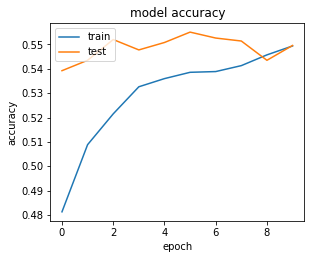

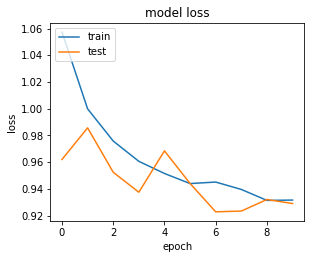

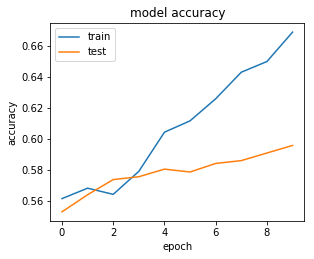

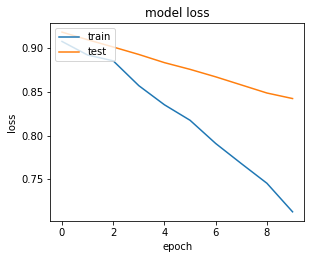

In [10]:
history = history1
# list all data in history
print(history.history.keys())

plt.figure()
# summarize history for accuracy
ax1 = plt.subplot(221)
ax1.plot(history1.history['acc'])
ax1.plot(history1.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#plt.figure(figsize = (15,4))
# summarize history for loss
ax2 = plt.subplot(222)
ax2.plot(history1.history['loss'])
ax2.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.subplot(223)
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#plt.figure(figsize = (15,4))
# summarize history for loss
plt.subplot(224)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
#Exporting the Kaggle submission

y_pred = model.predict(X_test, batch_size=32, verbose=1)
y = np.zeros((1,224,224,3))
images = []
for filename in os.listdir("/home/cedoz/kaggle_cervical/data/raw/test"):
    images.append(filename)
images = np.array(images)
images = images.reshape((-1,1))
output = np.append(images, y_pred, axis = 1)
colnames = np.array([["image_name","Type_1","Type_2","Type_3"]])
output = np.append(colnames, output, axis = 0)
np.savetxt("submission.csv", output, fmt='%s', delimiter=',', newline='\n')

512/512 [==============================] - 5s     


In [86]:
for i in range(images.shape[0]):
    images[i][0] = int(images[i][0][:-4])

In [88]:
test = np.append(images, output, axis = 1)

In [91]:
np.sort(output, axis=0, kind='quicksort', order=images)

ValueError: Cannot specify order when the array has no fields.